<a href="https://colab.research.google.com/github/jamesmuiru/mlfccourse/blob/main/Healthcare_Infrastructure_Optimization_in_Central_Kenya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Access

**Population Density data access**

In [3]:
import requests
import os

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define URL and output path
url = "https://data.worldpop.org/GIS/Population_Density/Global_2000_2020_1km/2020/KEN/ken_pd_2020_1km.tif"
output_dir = "/content/drive/MyDrive/Miniproject/Population_density"
os.makedirs(output_dir, exist_ok=True)  # make folder if not exists
output_path = os.path.join(output_dir, "ken_pd_2020_1km.tif")

# Download file
r = requests.get(url, allow_redirects=True, stream=True)
with open(output_path, 'wb') as f:
    for chunk in r.iter_content(chunk_size=8192):
        if chunk:
            f.write(chunk)

print(f"✅ File downloaded and saved to: {output_path}")


Mounted at /content/drive
✅ File downloaded and saved to: /content/drive/MyDrive/Miniproject/Population_density/ken_pd_2020_1km.tif


In [4]:
raster_populationdensity="/content/drive/MyDrive/Miniproject/Population_density/ken_pd_2020_1km.tif"
counties_boundaries="/content/drive/MyDrive/Miniproject/Boundaries/ken_admbndl_admALL_iebc_itos_20191031.shp"
point_health_facilities="/content/drive/MyDrive/Miniproject/hotosm_ken_health_facilities_points_shp/hotosm_ken_health_facilities_points_shp.shp"
lines_roads="/content/drive/MyDrive/Miniproject/roads/hotosm_ken_roads_lines_shp.shp"
average_household="/content/drive/MyDrive/Miniproject/kenya-average-household-size-by-sub-county.csv" ## V
distance_health_roads="/content/drive/MyDrive/Miniproject/distance_health_roads.tif"


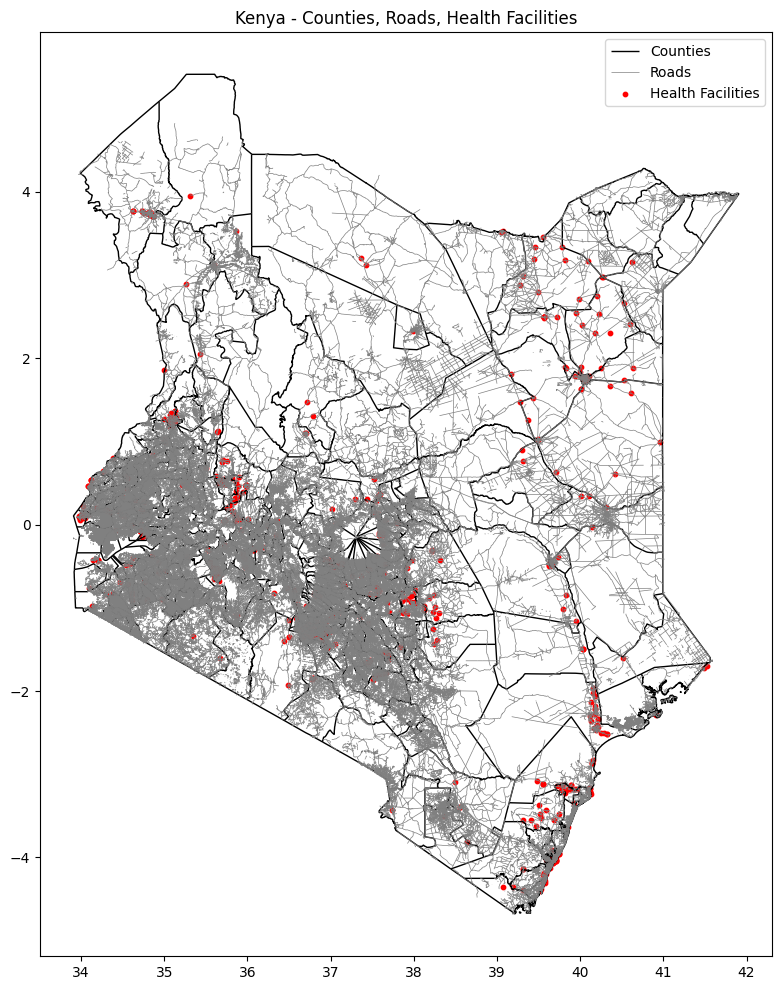

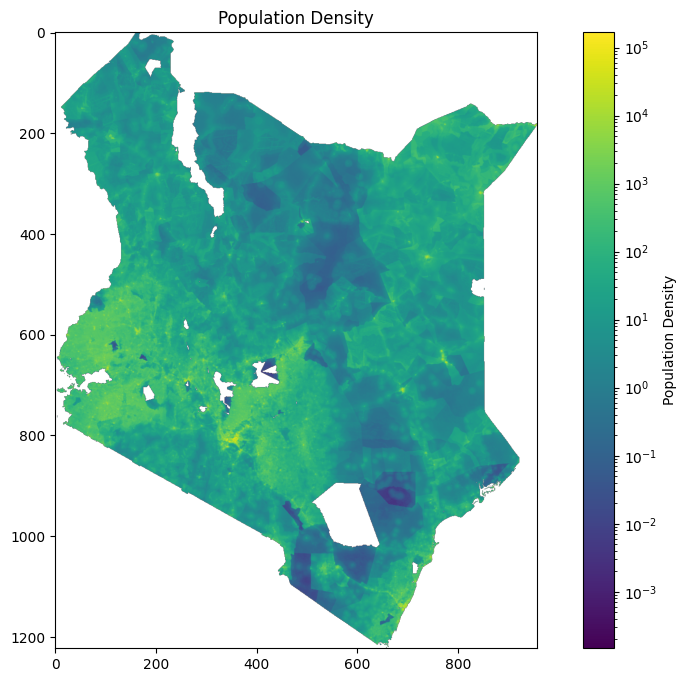

In [5]:
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
from matplotlib.colors import LogNorm
import pandas as pd # Import pandas

# Read vector datasets
gdf_counties = gpd.read_file(counties_boundaries)
gdf_health = gpd.read_file(point_health_facilities)
gdf_roads = gpd.read_file(lines_roads)
# Read CSV file using pandas
df_households = pd.read_csv(average_household)


# Plot vector datasets
fig, ax = plt.subplots(figsize=(12, 12))
gdf_counties.plot(ax=ax, facecolor="none", edgecolor="black", linewidth=1, label="Counties")
gdf_roads.plot(ax=ax, color="gray", linewidth=0.5, label="Roads")
gdf_health.plot(ax=ax, color="red", markersize=10, label="Health Facilities")
# Cannot plot df_households directly as it is not a GeoDataFrame
# gdf_households.plot(ax=ax, color="blue", markersize=5, label="Households")

# Add legend
plt.legend()
plt.title("Kenya - Counties, Roads, Health Facilities")
plt.show()

# Plot raster population density
src = rasterio.open(raster_populationdensity)
plt.figure(figsize=(12, 8))
plt.imshow(src.read(1), cmap="viridis",norm=LogNorm())
plt.colorbar(label="Population Density")
plt.title("Population Density")
plt.show()

In [6]:
## get the datasets properties
print(gdf_counties.crs)
print(gdf_health.crs)
print(gdf_roads.crs)
print(df_households.head())


EPSG:4326
EPSG:4326
EPSG:4326
                                          Unnamed: 0 Unnamed: 1
0               Average Household Size by Sub-County        NaN
1  Source: 2019 Kenya Population and Housing Cens...        NaN
2  https://wwwknbsorke/?wpdmpro=2019-kenya-popula...        NaN
3          Household size, Sub-county, County, Kenya        NaN
4                                                NaN        NaN


In [7]:
df_households_columns=[x for x in df_households.columns]


### Assess

In [8]:
import geopandas as gpd
import rasterio
from rasterio.features import rasterize
from rasterio.transform import from_bounds
import numpy as np
from scipy.ndimage import distance_transform_edt

# Paths


point_health_facilities = "/content/drive/MyDrive/Miniproject/hotosm_ken_health_facilities_points_shp/hotosm_ken_health_facilities_points_shp.shp"
lines_roads = "/content/drive/MyDrive/Miniproject/roads/hotosm_ken_roads_lines_shp.shp"


# -----------------------------
# 1. Load raster (population density) as reference grid
# -----------------------------
with rasterio.open(raster_populationdensity) as src:
    profile = src.profile
    transform = src.transform
    shape = src.shape
    crs = src.crs

# -----------------------------
# 2. Load vector data (health facilities and roads)
# -----------------------------
gdf_health = gpd.read_file(point_health_facilities).to_crs(crs)
gdf_roads = gpd.read_file(lines_roads).to_crs(crs)

# -----------------------------
# 3. Rasterize the facilities and roads
# -----------------------------
# Rasterize health facilities
health_raster = rasterize(
    [(geom, 1) for geom in gdf_health.geometry],
    out_shape=shape,
    transform=transform,
    fill=0,
    dtype="uint8"
)

# Rasterize roads
roads_raster = rasterize(
    [(geom, 1) for geom in gdf_roads.geometry],
    out_shape=shape,
    transform=transform,
    fill=0,
    dtype="uint8"
)

# -----------------------------
# 4. Compute Euclidean distance (in raster grid cells)
# -----------------------------
# Distance from health facilities
dist_health = distance_transform_edt(health_raster == 0) * profile["transform"][0]

# Distance from roads
dist_roads = distance_transform_edt(roads_raster == 0) * profile["transform"][0]

# -----------------------------
# 5. Combine results (example: minimum distance to either road or health facility)
# -----------------------------
dist_combined = np.minimum(dist_health, dist_roads)

# -----------------------------
# 6. Save output raster
# -----------------------------
output_path = "/content/drive/MyDrive/Miniproject/distance_health_roads.tif"

with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(dist_combined.astype(rasterio.float32), 1)

print("✅ Euclidean distance raster saved at:", output_path)


✅ Euclidean distance raster saved at: /content/drive/MyDrive/Miniproject/distance_health_roads.tif


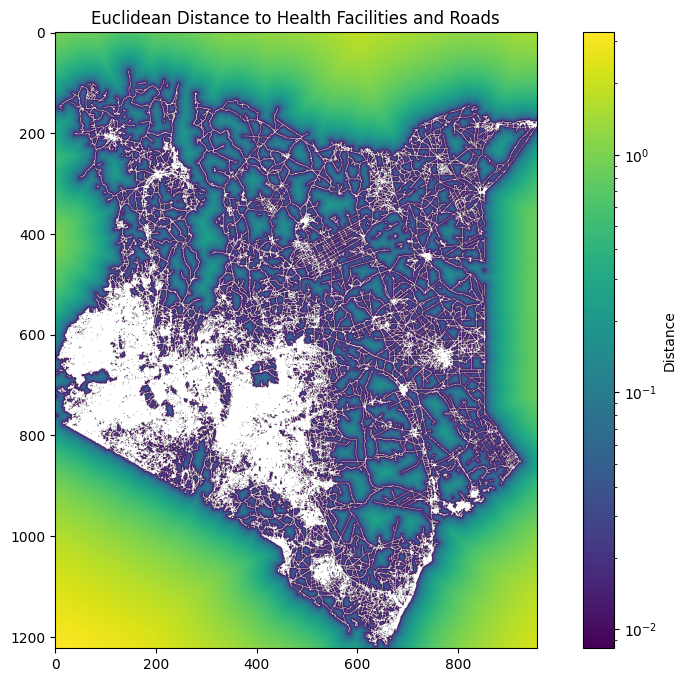

In [9]:
## plot this dataset /content/drive/MyDrive/Miniproject/distance_health_roads.tif
import matplotlib.pyplot as plt
import rasterio
distance_raster_path = "/content/drive/MyDrive/Miniproject/distance_health_roads.tif"
with rasterio.open(distance_raster_path) as src:
    profile = src.profile
    transform = src.transform
    shape = src.shape
    crs = src.crs
    distance_data = src.read(1)
    plt.figure(figsize=(12, 8))
    plt.imshow(distance_data, cmap="viridis",norm=LogNorm())
    plt.colorbar(label="Distance")
    plt.title("Euclidean Distance to Health Facilities and Roads")
    plt.show()

# clip based on the shapefile
shapefile="/content/drive/MyDrive/Miniproject/Boundaries/ken_admbndl_admALL_iebc_itos_20191031.shp"
gdf_counties = gpd.read_file(shapefile)

## Get Zonal statistics for each area

In [12]:
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats

# Paths
distance_raster_path = "/content/drive/MyDrive/Miniproject/distance_health_roads.tif"
constituency_boundaries = "/content/drive/MyDrive/Miniproject/Boundaries/ken_admbndl_admALL_iebc_itos_20191031.shp"

# -----------------------------
# 1. Load constituency boundaries
# -----------------------------
gdf_constituencies = gpd.read_file(constituency_boundaries)

# -----------------------------
# 2. Make sure CRS matches raster
# -----------------------------
with rasterio.open(distance_raster_path) as src:
    gdf_constituencies = gdf_constituencies.to_crs(src.crs)

# -----------------------------
# 3. Calculate mean distance per constituency
# -----------------------------
stats = zonal_stats(
    vectors=gdf_constituencies,
    raster=distance_raster_path,
    stats=["mean"],
    geojson_out=True
)

# -----------------------------
# 4. Convert results back to GeoDataFrame
# -----------------------------
gdf_with_mean = gpd.GeoDataFrame.from_features(stats)

# -----------------------------
# 5. Save as new shapefile/GeoPackage
# -----------------------------
output_path = "/content/drive/MyDrive/Miniproject/constituencies_with_mean_distance.shp"
gdf_with_mean.to_file(output_path)

print("✅ Constituencies with mean distance saved at:", output_path)
print(gdf_with_mean.head())


/usr/local/lib/python3.12/dist-packages/pyogrio/geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


✅ Constituencies with mean distance saved at: /content/drive/MyDrive/Miniproject/constituencies_with_mean_distance.shp
                                            geometry  Shape_Leng  admLevel  \
0  LINESTRING (39.22308 -4.66901, 39.22034 -4.671...    0.014668        99   
1  LINESTRING (39.21667 -4.66071, 39.21472 -4.662...    0.007563        99   
2  LINESTRING (39.22779 -4.6603, 39.22745 -4.6613...    0.019891        99   
3  LINESTRING (39.28229 -4.66699, 39.27832 -4.668...    0.048525        99   
4  LINESTRING (39.36432 -4.65521, 39.36768 -4.655...    0.127815        99   

        date    validON validTo      mean  
0 2018-06-07 2019-10-31    None  0.008333  
1 2018-06-07 2019-10-31    None  0.000000  
2 2018-06-07 2019-10-31    None  0.004167  
3 2018-06-07 2019-10-31    None  0.056510  
4 2018-06-07 2019-10-31    None  0.006402  


/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Field date create as date field, though DateTime requested.
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Field validON create as date field, though DateTime requested.
  ogr_write(


In [13]:
constituencies_mean_distance="/content/drive/MyDrive/Miniproject/constituencies_with_mean_distance.shp"
constituencies_mean_distance=gpd.read_file(constituencies_mean_distance)
constituencies_mean_distance.head(10)


,Shape_Leng,admLevel,date,validON,validTo,mean,geometry
0,0.014668,99,2018-06-07,2019-10-31,None,0.008333,"LINESTRING (39.22308 -4.66901, 39.22034 -4.671..."
1,0.007563,99,2018-06-07,2019-10-31,None,0.000000,"LINESTRING (39.21667 -4.66071, 39.21472 -4.662..."
2,0.019891,99,2018-06-07,2019-10-31,None,0.004167,"LINESTRING (39.22779 -4.6603, 39.22745 -4.6613..."
3,0.048525,99,2018-06-07,2019-10-31,None,0.056510,"LINESTRING (39.28229 -4.66699, 39.27832 -4.668..."
4,0.127815,99,2018-06-07,2019-10-31,None,0.006402,"LINESTRING (39.36432 -4.65521, 39.36768 -4.655..."
5,0.023417,99,2018-06-07,2019-10-31,None,0.002778,"LINESTRING (39.21667 -4.66071, 39.21667 -4.660..."
6,0.008071,99,2018-06-07,2019-10-31,None,0.018634,"LINESTRING (39.23413 -4.64728, 39.2323 -4.6500..."
7,0.007528,99,2018-06-07,2019-10-31,None,0.026352,"LINESTRING (39.24487 -4.6192, 39.24432 -4.6215..."
8,0.018769,99,2018-06-07,2019-10-31,None,0.025676,"LINESTRING (39.29187 -4.59607, 39.29132 -4.599..."
9,0.019899,99,2018-06-07,2019-10-31,None,0.010059,"LINESTRING (39.43011 -4.58191, 39.42767 -4.583..."


   Shape_Leng  admLevel       date    validON validTo      mean  \
0    0.014668        99 2018-06-07 2019-10-31    None  0.008333   
1    0.007563        99 2018-06-07 2019-10-31    None  0.000000   
2    0.019891        99 2018-06-07 2019-10-31    None  0.004167   
3    0.048525        99 2018-06-07 2019-10-31    None  0.056510   
4    0.127815        99 2018-06-07 2019-10-31    None  0.006402   
5    0.023417        99 2018-06-07 2019-10-31    None  0.002778   
6    0.008071        99 2018-06-07 2019-10-31    None  0.018634   
7    0.007528        99 2018-06-07 2019-10-31    None  0.026352   
8    0.018769        99 2018-06-07 2019-10-31    None  0.025676   
9    0.019899        99 2018-06-07 2019-10-31    None  0.010059   

                                            geometry  
0  LINESTRING (39.22308 -4.66901, 39.22034 -4.671...  
1  LINESTRING (39.21667 -4.66071, 39.21472 -4.662...  
2  LINESTRING (39.22779 -4.6603, 39.22745 -4.6613...  
3  LINESTRING (39.28229 -4.66699, 39.27832

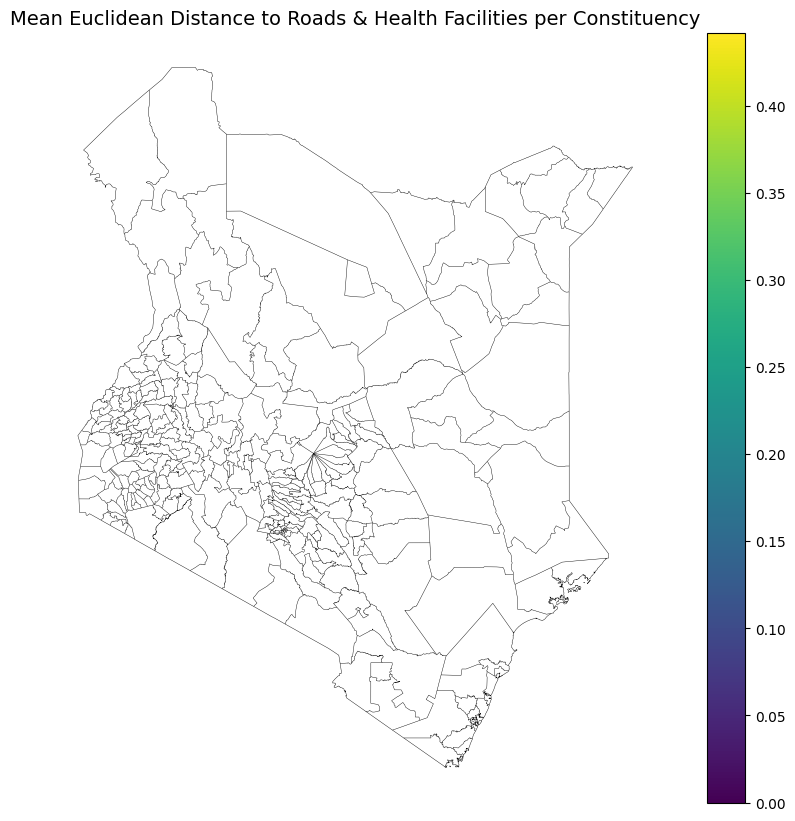

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Path to your shapefile with mean distances
constituencies_mean_distance = "/content/drive/MyDrive/Miniproject/constituencies_with_mean_distance.shp"

# Read the shapefile
gdf = gpd.read_file(constituencies_mean_distance)

# Check first 10 rows
print(gdf.head(10))

# -----------------------------
# Plot choropleth by mean distance
# -----------------------------
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

gdf.plot(
    column="mean",       # column with mean distance
    cmap="viridis",      # color map
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax
)

ax.set_title("Mean Euclidean Distance to Roads & Health Facilities per Constituency", fontsize=14)
ax.axis("off")

plt.show()


In [15]:
print(gdf["mean"].describe())
print(gdf[["mean"]].head(20))


count    891.000000
mean       0.007330
std        0.020903
min        0.000000
25%        0.000000
50%        0.000889
75%        0.007111
max        0.441931
Name: mean, dtype: float64
        mean
0   0.008333
1   0.000000
2   0.004167
3   0.056510
4   0.006402
5   0.002778
6   0.018634
7   0.026352
8   0.025676
9   0.010059
10  0.010510
11  0.016124
12  0.012262
13  0.011785
14  0.011785
15  0.009043
16  0.008333
17  0.000260
18  0.009790
19  0.000672


## Clip raster distance

✅ Raster clipped and saved at: /content/drive/MyDrive/Miniproject/distance_health_roads_clipped.tif


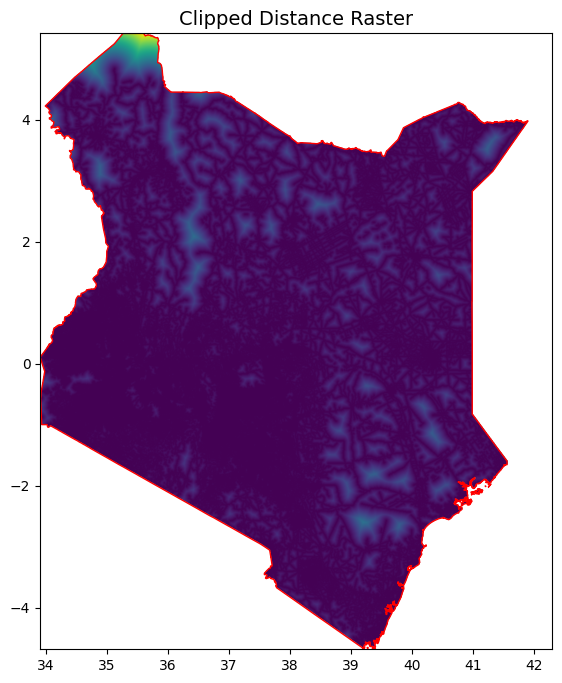

In [16]:
import rasterio
import rasterio.plot
from rasterio.mask import mask
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Paths
country_dataset = "/content/drive/MyDrive/Miniproject/Boundaries/ken_admbnda_adm0_iebc_20191031.shp"
distance_raster_path = "/content/drive/MyDrive/Miniproject/distance_health_roads.tif"
output_clipped = "/content/drive/MyDrive/Miniproject/distance_health_roads_clipped.tif"

# Read shapefile
gdf_country = gpd.read_file(country_dataset)

# Open raster
with rasterio.open(distance_raster_path) as src:
    # Reproject shapefile to raster CRS
    gdf_country = gdf_country.to_crs(src.crs)

    # Extract geometry
    geoms = gdf_country.geometry.values

    # Clip raster with mask
    out_image, out_transform = mask(src, geoms, crop=True)
    out_meta = src.meta.copy()

# Update metadata for clipped raster
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Save clipped raster
with rasterio.open(output_clipped, "w", **out_meta) as dest:
    dest.write(out_image)

print("✅ Raster clipped and saved at:", output_clipped)

# -------------------------------
# Plot clipped raster
# -------------------------------
with rasterio.open(output_clipped) as clipped:
    fig, ax = plt.subplots(figsize=(10, 8))
    rasterio.plot.show(clipped, ax=ax, cmap="viridis")
    gdf_country.boundary.plot(ax=ax, edgecolor="red", linewidth=1)
    plt.title("Clipped Distance Raster", fontsize=14)
    plt.show()


## Clip population

✅ Raster clipped and saved at: /content/drive/MyDrive/Miniproject/masked_population_density.tif


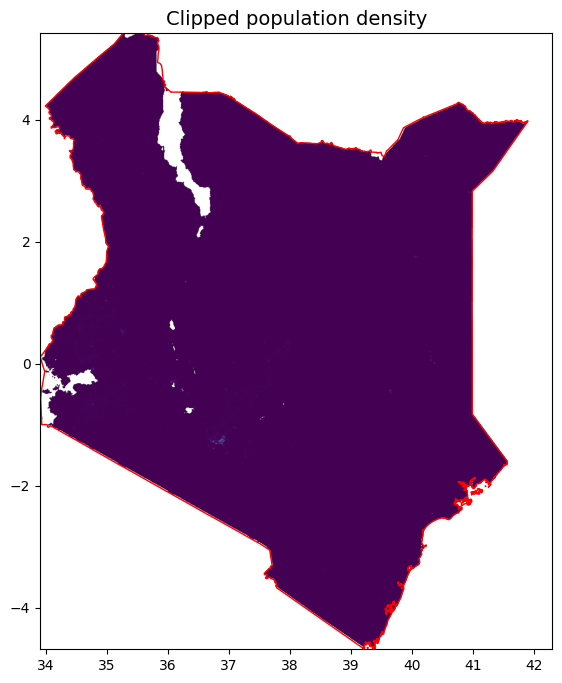

In [17]:
import rasterio
import rasterio.plot
from rasterio.mask import mask
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Paths
country_dataset = "/content/drive/MyDrive/Miniproject/Boundaries/ken_admbnda_adm0_iebc_20191031.shp"

raster_populationdensity="/content/drive/MyDrive/Miniproject/Population_density/ken_pd_2020_1km.tif"
output_clipped = "/content/drive/MyDrive/Miniproject/masked_population_density.tif"

# Read shapefile
gdf_country = gpd.read_file(country_dataset)

# Open raster
with rasterio.open(raster_populationdensity) as src:
    # Reproject shapefile to raster CRS
    gdf_country = gdf_country.to_crs(src.crs)

    # Extract geometry
    geoms = gdf_country.geometry.values

    # Clip raster with mask
    out_image, out_transform = mask(src, geoms, crop=True)
    out_meta = src.meta.copy()

# Update metadata for clipped raster
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Save clipped raster
with rasterio.open(output_clipped, "w", **out_meta) as dest:
    dest.write(out_image)

print("✅ Raster clipped and saved at:", output_clipped)

# -------------------------------
# Plot clipped raster
# -------------------------------
with rasterio.open(output_clipped) as clipped:
    fig, ax = plt.subplots(figsize=(10, 8))
    rasterio.plot.show(clipped, ax=ax, cmap="viridis")
    gdf_country.boundary.plot(ax=ax, edgecolor="red", linewidth=1)
    plt.title("Clipped population density", fontsize=14)
    plt.show()


In [18]:
distance_health_roads="/content/drive/MyDrive/Miniproject/distance_health_roads_clipped.tif"
country_dataset="/content/drive/MyDrive/Miniproject/Boundaries/ken_admbnda_adm0_iebc_20191031.shp"
raster_populationdensity="/content/drive/MyDrive/Miniproject/Population_density/ken_pd_2020_1km.tif"
counties_boundaries="/content/drive/MyDrive/Miniproject/Boundaries/ken_admbndl_admALL_iebc_itos_20191031.shp"
point_health_facilities="/content/drive/MyDrive/Miniproject/hotosm_ken_health_facilities_points_shp/hotosm_ken_health_facilities_points_shp.shp"
lines_roads="/content/drive/MyDrive/Miniproject/roads/hotosm_ken_roads_lines_shp.shp"
average_household="/content/drive/MyDrive/Miniproject/kenya-average-household-size-by-sub-county.csv"


In [19]:
import geopandas as gpd
import pandas as pd
import rasterio

# Paths
distance_health_roads = "/content/drive/MyDrive/Miniproject/distance_health_roads_clipped.tif"
country_dataset = "/content/drive/MyDrive/Miniproject/Boundaries/ken_admbnda_adm0_iebc_20191031.shp"
raster_populationdensity = "/content/drive/MyDrive/Miniproject/Population_density/ken_pd_2020_1km.tif"
counties_boundaries = "/content/drive/MyDrive/Miniproject/Boundaries/ken_admbndl_admALL_iebc_itos_20191031.shp"
point_health_facilities = "/content/drive/MyDrive/Miniproject/hotosm_ken_health_facilities_points_shp/hotosm_ken_health_facilities_points_shp.shp"
lines_roads = "/content/drive/MyDrive/Miniproject/roads/hotosm_ken_roads_lines_shp.shp"
average_household = "/content/drive/MyDrive/Miniproject/kenya-average-household-size-by-sub-county.csv"

# --- Raster files (inspect metadata instead of columns) ---
def inspect_raster(path):
    with rasterio.open(path) as src:
        print(f"\n📂 Raster: {path}")
        print("Bands:", src.count)
        print("Width x Height:", src.width, "x", src.height)
        print("CRS:", src.crs)
        print("Bounds:", src.bounds)
        print("First 3 values from band 1:", src.read(1).ravel()[:3])

inspect_raster(distance_health_roads)
inspect_raster(raster_populationdensity)

# --- Vector shapefiles ---
def inspect_vector(path):
    gdf = gpd.read_file(path)
    print(f"\n📂 Vector: {path}")
    print("Columns:", list(gdf.columns))
    print("First 3 rows:\n", gdf.head(7))
    return gdf

gdf_country = inspect_vector(country_dataset)
gdf_counties = inspect_vector(counties_boundaries)
gdf_health = inspect_vector(point_health_facilities)
gdf_roads = inspect_vector(lines_roads)

# --- CSV ---
df_households = pd.read_csv(average_household)
print(f"\n📂 CSV: {average_household}")
print("Columns:", list(df_households.columns))
print("First 3 rows:\n", df_households.head(3))



📂 Raster: /content/drive/MyDrive/Miniproject/distance_health_roads_clipped.tif
Bands: 1
Width x Height: 957 x 1212
CRS: EPSG:4326
Bounds: BoundingBox(left=33.9070832014676, bottom=-4.683749773636145, right=41.8820831695676, top=5.416250185963855)
First 3 values from band 1: [-99999. -99999. -99999.]

📂 Raster: /content/drive/MyDrive/Miniproject/Population_density/ken_pd_2020_1km.tif
Bands: 1
Width x Height: 957 x 1223
CRS: EPSG:4326
Bounds: BoundingBox(left=33.9070832014676, bottom=-4.725416440136145, right=41.8820831695676, top=5.466250185763855)
First 3 values from band 1: [-99999. -99999. -99999.]

📂 Vector: /content/drive/MyDrive/Miniproject/Boundaries/ken_admbnda_adm0_iebc_20191031.shp
Columns: ['Shape_Leng', 'Shape_Area', 'ADM0_EN', 'ADM0_PCODE', 'ADM0_REF', 'ADM0ALT1EN', 'ADM0ALT2EN', 'date', 'validOn', 'validTo', 'geometry']
First 3 rows:
    Shape_Leng  Shape_Area ADM0_EN ADM0_PCODE ADM0_REF ADM0ALT1EN ADM0ALT2EN  \
0   44.052413   48.098756   Kenya         KE     None       

In [20]:
population_density_file="/content/drive/MyDrive/Miniproject/masked_population_density.tif"
health_roads="/content/drive/MyDrive/Miniproject/distance_health_roads_clipped.tif"
costituencies="/content/drive/MyDrive/Miniproject/Boundaries/ken_admbnda_adm2_iebc_20191031.shp"



In [21]:
constituencies=gpd.read_file(costituencies)
constituencies.head()

,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,ValidTo,geometry
0,1.746986,0.040829,Ainabkoi,KE027144,None,None,None,Uasin Gishu,KE027,Kenya,KE,2017-11-03,2019-10-31,NaT,"POLYGON ((35.35933 0.52108, 35.36047 0.52079, ..."
1,0.917307,0.019957,Ainamoi,KE035190,None,None,None,Kericho,KE035,Kenya,KE,2017-11-03,2019-10-31,NaT,"POLYGON ((35.26262 -0.23064, 35.26395 -0.23135..."
2,1.402637,0.038000,Aldai,KE029152,None,None,None,Nandi,KE029,Kenya,KE,2017-11-03,2019-10-31,NaT,"POLYGON ((34.93989 0.08211, 34.9436 0.08175, 3..."
3,1.081354,0.049357,Alego Usonga,KE041234,None,None,None,Siaya,KE041,Kenya,KE,2017-11-03,2019-10-31,NaT,"POLYGON ((34.20727 0.15971, 34.20937 0.1592, 3..."
4,0.743915,0.021365,Awendo,KE044254,None,None,None,Migori,KE044,Kenya,KE,2017-11-03,2019-10-31,NaT,"POLYGON ((34.54577 -0.7482, 34.54787 -0.7513, ..."


In [22]:
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats

# Paths
population_density_file = "/content/drive/MyDrive/Miniproject/masked_population_density.tif"
health_roads = "/content/drive/MyDrive/Miniproject/distance_health_roads_clipped.tif"
constituencies = "/content/drive/MyDrive/Miniproject/Boundaries/ken_admbnda_adm2_iebc_20191031.shp"
output_shapefile = "/content/drive/MyDrive/Miniproject/Boundaries/constituencies_with_stats.shp"

# Load constituencies
gdf_const = gpd.read_file(constituencies)

# --- Mean Population Density ---
stats_pop = zonal_stats(
    gdf_const,
    population_density_file,
    stats=["mean"],
    nodata=None,
    geojson_out=False
)

# --- Mean Distance to Health/Roads ---
stats_health = zonal_stats(
    gdf_const,
    health_roads,
    stats=["mean"],
    nodata=None,
    geojson_out=False
)

# Add results as new columns
gdf_const["mean_pop_density"] = [s["mean"] for s in stats_pop]
gdf_const["mean_distance_health_roads"] = [s["mean"] for s in stats_health]

# Save updated shapefile
gdf_const.to_file(output_shapefile)

print("✅ Zonal statistics completed and saved to:", output_shapefile)
print(gdf_const[["mean_pop_density", "mean_distance_health_roads"]].head())


/tmp/ipython-input-4199606258.py:37: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_const.to_file(output_shapefile)


✅ Zonal statistics completed and saved to: /content/drive/MyDrive/Miniproject/Boundaries/constituencies_with_stats.shp
   mean_pop_density  mean_distance_health_roads
0        309.248096                    0.000742
1        851.060467                    0.000143
2        492.913453                    0.002069
3        393.381925                    0.001153
4        533.473127                    0.000391


/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Field date create as date field, though DateTime requested.
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Field validOn create as date field, though DateTime requested.
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Field ValidTo create as date field, though DateTime requested.
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'mean_pop_density' to 'mean_pop_d'
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'mean_distance_health_roads' to 'mean_dista'
  ogr_write(


In [23]:
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats

# Paths
population_density_file = "/content/drive/MyDrive/Miniproject/masked_population_density.tif"
health_roads = "/content/drive/MyDrive/Miniproject/distance_health_roads_clipped.tif"
constituencies = "/content/drive/MyDrive/Miniproject/Boundaries/ken_admbnda_adm2_iebc_20191031.shp"
output_shapefile = "/content/drive/MyDrive/Miniproject/Boundaries/constituencies_with_stats.shp"

# Load constituencies
gdf_const = gpd.read_file(constituencies)

# --- Mean Population Density ---
stats_pop = zonal_stats(
    gdf_const,
    population_density_file,
    stats=["mean"],
    nodata=None,
    geojson_out=False
)

# --- Mean Distance to Health/Roads (in degrees) ---
stats_health = zonal_stats(
    gdf_const,
    health_roads,
    stats=["mean"],
    nodata=None,
    geojson_out=False
)

# Add results as new columns
gdf_const["mean_pop_density"] = [s["mean"] for s in stats_pop]
gdf_const["mean_distance_deg"] = [s["mean"] for s in stats_health]

# Convert degrees → meters (approx: 1° ≈ 111.32 km)
deg_to_m = 111320
gdf_const["mean_distance_m"] = gdf_const["mean_distance_deg"] * deg_to_m

# Save updated shapefile
gdf_const.to_file(output_shapefile)

print("✅ Zonal statistics completed and saved to:", output_shapefile)
print(gdf_const[["mean_pop_density", "mean_distance_deg", "mean_distance_m"]].head())


/tmp/ipython-input-1816157178.py:41: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_const.to_file(output_shapefile)
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Field date create as date field, though DateTime requested.
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Field validOn create as date field, though DateTime requested.
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Field ValidTo create as date field, though DateTime requested.
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'mean_pop_density' to 'mean_pop_d'
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'mean_distance_deg' to 'mean_dista'
  ogr_write(
/usr/local/lib/python3.12/dist-packages/pyogrio/raw.py:72

✅ Zonal statistics completed and saved to: /content/drive/MyDrive/Miniproject/Boundaries/constituencies_with_stats.shp
   mean_pop_density  mean_distance_deg  mean_distance_m
0        309.248096           0.000742        82.653135
1        851.060467           0.000143        15.884702
2        492.913453           0.002069       230.285182
3        393.381925           0.001153       128.390392
4        533.473127           0.000391        43.555650


Index(['Shape_Leng', 'Shape_Area', 'ADM2_EN', 'ADM2_PCODE', 'ADM2_REF',
       'ADM2ALT1EN', 'ADM2ALT2EN', 'ADM1_EN', 'ADM1_PCODE', 'ADM0_EN',
       'ADM0_PCODE', 'date', 'validOn', 'ValidTo', 'mean_pop_d', 'mean_dista',
       'mean_dis_1', 'geometry'],
      dtype='object')


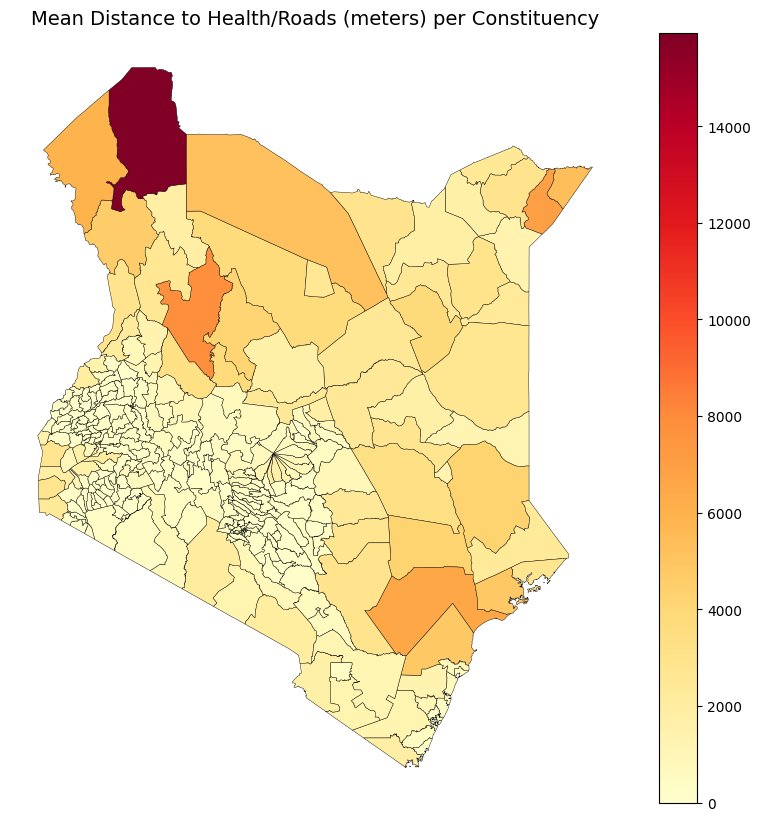

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the updated shapefile with stats
gdf_const = gpd.read_file(output_shapefile)

# Print column names to identify the correct column for plotting
print(gdf_const.columns)

# Plot choropleth based on mean distance (in meters)
fig, ax = plt.subplots(figsize=(10, 10))
gdf_const.plot(
    column="mean_dis_1",      # the column to base color on
    cmap="YlOrRd",                 # color map (Yellow → Red)
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax
)

# Add title
ax.set_title("Mean Distance to Health/Roads (meters) per Constituency", fontsize=14)

# Remove axis
ax.set_axis_off()

plt.show()

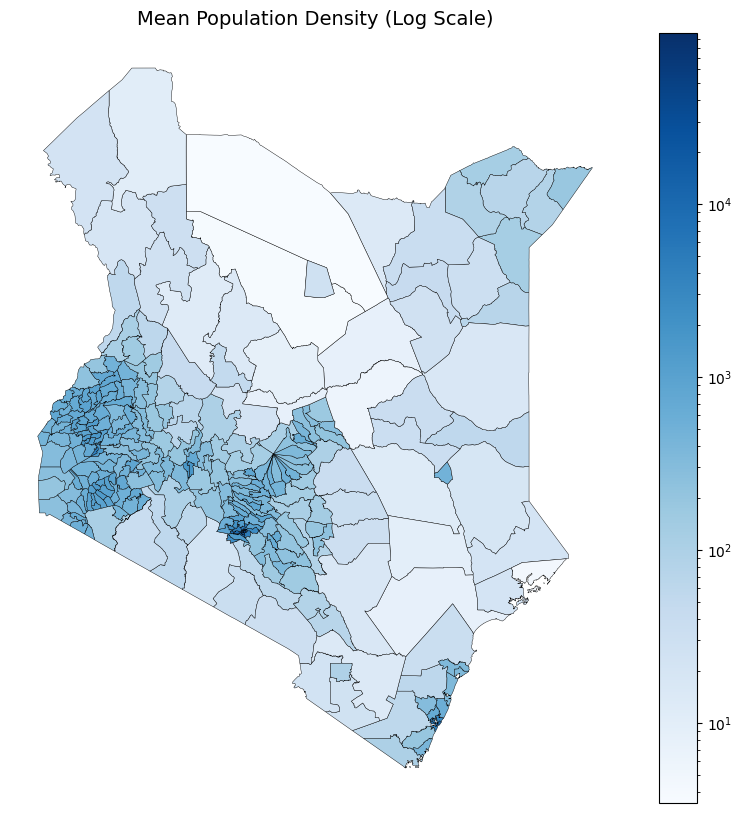

In [31]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

# Load shapefile
gdf_const = gpd.read_file(output_shapefile)

# Plot with log scale
fig, ax = plt.subplots(figsize=(10, 10))
gdf_const.plot(
    column="mean_pop_d",
    cmap="Blues",
    norm=colors.LogNorm(vmin=gdf_const["mean_pop_d"].min()+1,
                        vmax=gdf_const["mean_pop_d"].max()),
    legend=True,
    edgecolor="black",
    linewidth=0.3,
    ax=ax
)

ax.set_title("Mean Population Density (Log Scale)", fontsize=14)
ax.set_axis_off()
plt.show()
